In [ ]:
#%pip install google-cloud-bigquery
#%pip install db-dtypes
#%pip install pandas-gbq

In [66]:
query = f"""
with join_rn as (SELECT o.user_id,
                      order_items_id,
                      sess_created_at,
                      order_created_at,
                      shipped_at,
                      session_id,
                      event_id
                FROM (select `org_data.events`.user_id,
                      `org_data.events`.event_type,
                      `org_data.events`.created_at `sess_created_at`,
                      `org_data.events`.session_id,
                      `org_data.events`.id `event_id`,
                      row_number() over(partition by cast(`org_data.events`.user_id AS string) order by `org_data.events`.created_at) rn
                      from `org_data.events`
                      where `org_data.events`.event_type='purchase') e
              inner join (select user_id,
                        `org_data.order_items`.id `order_items_id`,
                        `org_data.order_items`.created_at `order_created_at`,
                        `org_data.order_items`.shipped_at `shipped_at`,
                        row_number() over(partition by `org_data.order_items`.user_id order by `org_data.order_items`.created_at) rn
                        from `org_data.order_items`) o
              on e.user_id=o.user_id
                and e.rn = o.rn
)

select 
  uoe.* EXCEPT(`inventory_item_id`, `product_id`),
  iv.id `inventory_item_id`,
  iv.product_id,
  iv.product_category `category`,
  iv.product_brand `brand`,
  iv.product_name,
  CAST(iv.created_at AS DATE) `inventory_created_at`,
  CAST(sold_at AS DATE) `inventory_sold_at`,
  iv.cost
from
  (select 
    uo.*,
    oi.id `order_items_id`,
    oi.product_id,
    oi.inventory_item_id,
    oi.status,
    oi.sale_price,
    oi.created_at `order_created_at`,
    oi.shipped_at,
    oi.delivered_at,
    oi.returned_at,
    e.id `event_id`,
    e.session_id,
    e.sequence_number,
    e.user_id `login_user_id`,
    e.created_at `sess_created_at`,
    e.traffic_source `sess_traffic_source`,
    e.uri,
    e.event_type,
    e.ip_address,
    e.state `sess_state`,
    e.city `sess_city`
  from
    (select u.id `user_id`,
      u.age,
      u.gender,
      u.state `account_state`,
      u.city `account_city`,
      u.country `account_country`,
      u.latitude,
      u.longitude,
      u.traffic_source `account_traffic_source`,
      u.created_at `account_created_at`,
      o.order_id,
    FROM `org_data.users` u
    FULL OUTER JOIN `org_data.orders` o
        on o.user_id=u.id) uo
  FULL OUTER JOIN `org_data.order_items` oi
    on oi.user_id=uo.user_id and oi.order_id=uo.order_id
  FULL OUTER JOIN join_rn
    on join_rn.user_id=uo.user_id
    and join_rn.order_items_id=oi.id
  FULL OUTER JOIN `org_data.events` e
    on (uo.user_id=e.user_id
    and join_rn.event_id=e.id
    and e.event_type='purchase')
  where e.session_id not in (select session_id
                          from join_rn
                          where join_rn.shipped_at < join_rn.order_created_at)    --created_at 보다 과거인 shipped을 갖는 세션은 제거
    and (
        ((oi.shipped_at >= oi.created_at) or (oi.shipped_at is null))          --shipped 정보가 있으면 created_at 보다 클 경우인 주문만
          or ((uo.account_created_at is null) and (e.created_at is not null))  --비회원, 세션만 존재
        )
    or ((uo.account_created_at is not null) and (oi.created_at is null))          --회원, 주문 null (세션 유무 상관없음)
  ) uoe
FULL OUTER JOIN `org_data.inventory_items` iv
  on iv.id=uoe.inventory_item_id
  """

In [67]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./looker-ecommerce-e30fc40090ce.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

# 데이터 조회 예시 쿼리문 
# FROM절 프로젝트명.데이터셋명.테이블명
query = query
check = client.query(query).to_dataframe()
check

,user_id,age,gender,account_state,account_city,account_country,latitude,longitude,account_traffic_source,account_created_at,...,sess_state,sess_city,inventory_item_id,product_id,category,brand,product_name,inventory_created_at,inventory_sold_at,cost
0,84583,42,F,Paraná,Londrina,Brasil,-23.291597,-51.158522,Search,2019-02-01 13:21:00+00:00,...,Paraná,Londrina,415229,8497,Outerwear & Coats,Marmot,Marmot Safire Jacket - Women's,2021-02-17,NaT,69.300000
1,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,São Paulo,Itararé,<NA>,<NA>,None,None,None,NaT,NaT,NaN
2,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,California,Sacramento,<NA>,<NA>,None,None,None,NaT,NaT,NaN
3,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,Guangdong,Yinchuan,<NA>,<NA>,None,None,None,NaT,NaT,NaN
4,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,Washington,Camas,<NA>,<NA>,None,None,None,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466226,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,274795,1504,Sweaters,CARRAIG DONN KNITWEAR,Irish Made Lined Shetland Wool Zipper Cardigan,2023-10-11,2023-12-07,40.079949
2466227,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,403807,1341,Sweaters,Minnie Rose,Minnie Rose Women's Pow Wow Sweater,2022-11-09,NaT,90.159843
2466228,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,351857,13051,Swim,Beach Joy,Sexy Retro Padded Ruffle Halter One Piece Black,2022-07-24,2022-08-10,13.855801
2466229,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,193355,399,Tops & Tees,Cosabella,Cosabella Women's Talco Long Camisole,2023-11-14,2023-11-22,41.616000


In [68]:
check.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466231 entries, 0 to 2466230
Data columns (total 37 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   user_id                 165843 non-null   Int64              
 1   age                     165843 non-null   Int64              
 2   gender                  165843 non-null   object             
 3   account_state           165843 non-null   object             
 4   account_city            165843 non-null   object             
 5   account_country         165843 non-null   object             
 6   latitude                165843 non-null   float64            
 7   longitude               165843 non-null   float64            
 8   account_traffic_source  165843 non-null   object             
 9   account_created_at      165843 non-null   datetime64[us, UTC]
 10  order_id                145887 non-null   Int64              
 11  order_items

In [69]:
# check.to_csv('./looker_(datetime).csv', index=False)

In [70]:
df = check.copy()

카이 제곱 검정
- 신규 유저 (실험군) vs 기존 유저 (대조군)
1. 개인 정보: 성별, 연령대, 국가, 유입경로, `→ same` @하늘
    - 구매 전환율 (1번 이상 결제), retention (2번 이상 결제) `→ diff` @영아
2. 구매 상품: product_id, category, brand, … `→ same` @지은
    - top 3

In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats

In [3]:
df = pd.read_csv('./looker_(datetime).csv')

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_14986/3448098404.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./looker_(datetime).csv')


In [4]:
# 형변환
def convert_type(df):
    for col in df.columns:
        if '_at' in col:    # 시간 데이터
            try:
                df = df.assign(**{col:pd.to_datetime(df[col])})
            except:
                df = df.assign(**{col:pd.to_datetime(df[col], format='ISO8601')})
            print('[+] {0:<30} >>> datetime'.format(col))
        elif '_id' in col:  # id 컬럼 -> obj형으로
            df = df.assign(**{col:df[col].astype('object')})
            print('[+] {0:<30} >>> object'.format(col))
    return df

In [5]:
df = convert_type(df)

[+] user_id                        >>> object
[+] account_created_at             >>> datetime
[+] order_id                       >>> object
[+] order_items_id                 >>> object
[+] order_created_at               >>> datetime
[+] shipped_at                     >>> datetime
[+] delivered_at                   >>> datetime
[+] returned_at                    >>> datetime
[+] event_id                       >>> object
[+] session_id                     >>> object
[+] login_user_id                  >>> object
[+] sess_created_at                >>> datetime
[+] inventory_item_id              >>> object
[+] product_id                     >>> object
[+] inventory_created_at           >>> datetime
[+] inventory_sold_at              >>> datetime


In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466231 entries, 0 to 2466230
Data columns (total 37 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   user_id                 165843 non-null   object             
 1   age                     165843 non-null   float64            
 2   gender                  165843 non-null   object             
 3   account_state           165843 non-null   object             
 4   account_city            164274 non-null   object             
 5   account_country         165843 non-null   object             
 6   latitude                165843 non-null   float64            
 7   longitude               165843 non-null   float64            
 8   account_traffic_source  165843 non-null   object             
 9   account_created_at      165843 non-null   datetime64[ns, UTC]
 10  order_id                145887 non-null   object             
 11  order_items

In [7]:
# 실험군: 2024 신규 유입 유저
treatment = df[df.account_created_at >= '2024-01-11'].copy()

In [8]:
# 대조군: 기존 유저
# control = df[df.account_created_at.dt.year==2023].copy()   # 2023년 가입 유저
control = df[df.account_created_at < '2024-01-11'].copy()

In [9]:
print(
    f'전체 유저 수 : {df.user_id.nunique(dropna=True)}명\n\
실험군 (treatment) : {treatment.user_id.nunique()}명\n\
대조군 (control) : {control.user_id.nunique()}명'
    )

전체 유저 수 : 96874명
실험군 (treatment) : 2664명
대조군 (control) : 94210명


In [10]:
chk_order = df.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()

<Axes: ylabel='Frequency'>

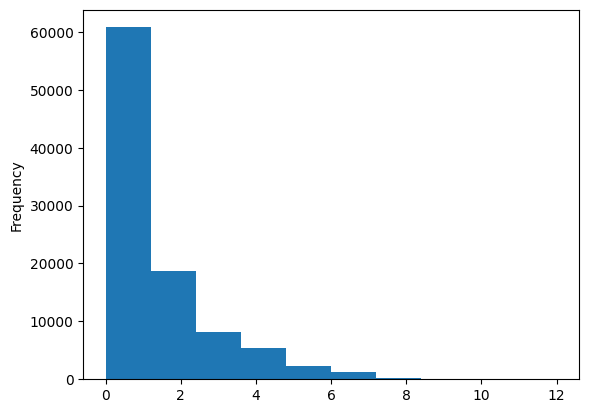

In [11]:
chk_order['order_items_id'].plot.hist()

In [12]:
chk_order_test = treatment.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()
chk_order_control = control.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()

In [13]:
test_order_0 = len(chk_order_test[chk_order_test.order_items_id == 0])
test_order_purchase = len(chk_order_test[chk_order_test.order_items_id != 0])
test_order_repurchase = len(chk_order_test[chk_order_test.order_items_id > 1])

In [14]:
control_order_0 = len(chk_order_control[chk_order_control.order_items_id == 0])
control_order_purchase = len(chk_order_control[chk_order_control.order_items_id != 0])
control_order_repurchase = len(chk_order_control[chk_order_control.order_items_id > 1])

### 구매율

In [15]:
## Part1. Chi-square Test Report
purchase = [test_order_purchase, control_order_purchase] # A와 B의 구매한 유저 수
non_purchase = [test_order_0, control_order_0]  # A와 B의 구매 안 한 유저 수

## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([purchase, non_purchase], columns=['treatment', 'control'], index=['purchase', 'non_purchase'])

## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = stats.chi2_contingency([purchase, non_purchase])

## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['purchase', 'non_purchase'])

print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )

  
[Chi-square Analysis Result Report]
Chi-square: 0.74
P-value: 0.39
--------------------------
Expected Values
               treatment      control
purchase      2115.21721  74802.78279
non_purchase   548.78279  19407.21721
--------------------------
Observed Values
              treatment  control
purchase           2097    74821
non_purchase        567    19389
 


In [16]:
# 실험군
1541 / (1541 + 567)

0.7310246679316889

In [17]:
# 대조군
54111 / (54111 + 19389)

0.736204081632653

### 재구매율

In [18]:
## Part1. Chi-square Test Report
purchase = [test_order_purchase, control_order_purchase] # A와 B의 구매한 유저 수
repurchase = [test_order_repurchase, control_order_repurchase]  # A와 B의 재구매한 유저 수
 
## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([purchase, repurchase], columns=['treatment', 'control'], index=['purchase', 'repurchase'])
 
## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = stats.chi2_contingency([purchase, repurchase])
 
## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['purchase', 'repurchase'])
 
print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )

  
[Chi-square Analysis Result Report]
Chi-square: 0.58
P-value: 0.45
--------------------------
Expected Values
            treatment     control
purchase    2117.0404  74800.9596
repurchase   992.9596  35084.0404
--------------------------
Observed Values
            treatment  control
purchase         2097    74821
repurchase       1013    35064
 


In [19]:
519 / (1541 + 519)

0.2519417475728155

In [20]:
17550 / (17550 + 54111)

0.24490308536023778

P-value가 0.29로 0.05보다 크다 -> 두 그룹의 차이가 없다... => 재구매율은 신규 유저가 좀 더 크다

### 가입 시점 ~ 첫 결제일

In [58]:
first_order = df.groupby('user_id').order_created_at.min().to_frame().merge(df[['user_id', 'account_created_at']], on='user_id', suffixes=('', '_first'))

In [59]:
first_order = convert_type(first_order)

[+] user_id                        >>> object
[+] order_created_at               >>> datetime
[+] account_created_at             >>> datetime


In [60]:
first_order = first_order.assign(order_diff=first_order['order_created_at'] - first_order['account_created_at'])
first_order = first_order.assign(order_diff=first_order.order_diff.dt.days)

In [61]:
first_order.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165843 entries, 0 to 165842
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   user_id             165843 non-null  object             
 1   order_created_at    145887 non-null  datetime64[ns, UTC]
 2   account_created_at  165843 non-null  datetime64[ns, UTC]
 3   order_diff          145887 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(1), object(1)
memory usage: 5.1+ MB


In [62]:
# 실험군: 2024 신규 유입 유저 / 대조군: 기존 유저
first_order.loc[first_order.account_created_at >= '2024-01-11', 'grp'] = 'treatment'
first_order.loc[first_order.account_created_at < '2024-01-11', 'grp'] = 'control'

In [63]:
test_first_order = first_order[first_order.grp=='treatment'].order_diff
first_order_max = test_first_order.max()
ctrl_first_order = first_order[(first_order.grp=='control') & (first_order.order_diff <= first_order_max)].order_diff

In [64]:
var_test = np.var(test_first_order)
var_ctrl = np.var(ctrl_first_order)

print('지불 금액의 분산: 실험군 {:.2f}일 vs 대조군 {:.2f}일'.format(var_test, var_ctrl))

if (var_test > var_ctrl * 2) or (var_ctrl > var_test * 2):
    print('분산이 2배 이상 차이나므로, Welch\'s t-test')
    equal_var=False
else:
    print('분산이 같으므로, Student\'s t-test')
    equal_var=True

지불 금액의 분산: 실험군 0.83일 vs 대조군 3.81일
분산이 2배 이상 차이나므로, Welch's t-test


In [66]:
t_stat, p_val = stats.ttest_ind(test_first_order.dropna(), 
                                ctrl_first_order.dropna(),
                                equal_var=equal_var)

print('t-statistic:', t_stat, '   p-value:', p_val)

if p_val < 0.05:
    print('두 그룹이 차이가 있다.')
else:
    print('두 그룹이 차이가 없다.')

t-statistic: -81.44174638308463    p-value: 0.0
두 그룹이 차이가 있다.


### 가입 시점 ~ 두 번째 결제일

In [67]:
# 2번 이상 구매한 유저 대상
ret = df.groupby('user_id').order_id.count().to_frame()
ret_user_list = ret[ret.order_id >= 2].index

In [68]:
second_order = df[df.user_id.isin(ret_user_list)].groupby('user_id').order_created_at.apply(lambda x: sorted(x)[1]).to_frame()
second_order = second_order.merge(df[['user_id', 'account_created_at']], on='user_id', how='left').drop_duplicates()

In [69]:
second_order = convert_type(second_order)

[+] user_id                        >>> object
[+] order_created_at               >>> datetime
[+] account_created_at             >>> datetime


In [70]:
second_order = second_order.assign(order_diff=second_order['order_created_at'] - second_order['account_created_at'])
second_order = second_order.assign(order_diff=second_order.order_diff.dt.days)

In [71]:
second_order.loc[second_order.account_created_at >= '2024-01-11', 'grp'] = 'treatment'
second_order.loc[second_order.account_created_at < '2024-01-11', 'grp'] = 'control'

In [72]:
test_second_order = second_order[second_order.grp=='treatment'].order_diff
second_order_max = test_second_order.max()
ctrl_second_order = second_order[(second_order.grp=='control') & (second_order.order_diff <= second_order_max)].order_diff

In [73]:
var_test = np.var(test_second_order)
var_ctrl = np.var(ctrl_second_order)

print('지불 금액의 분산: 실험군 {:.2f}일 vs 대조군 {:.2f}일'.format(var_test, var_ctrl))

if (var_test > var_ctrl * 2) or (var_ctrl > var_test * 2):
    print('분산이 2배 이상 차이나므로, Welch\'s t-test')
    equal_var=False
else:
    print('분산이 같으므로, Student\'s t-test')
    equal_var=True

지불 금액의 분산: 실험군 1.90일 vs 대조군 3.81일
분산이 2배 이상 차이나므로, Welch's t-test


In [74]:
t_stat, p_val = stats.ttest_ind(test_second_order, 
                                ctrl_second_order,
                                equal_var=equal_var)

print('t-statistic:', t_stat, '   p-value:', p_val)

if p_val < 0.05:
    print('두 그룹이 차이가 있다.')
else:
    print('두 그룹이 차이가 없다.')

t-statistic: -33.70995481558469    p-value: 1.2820131820945723e-155
두 그룹이 차이가 있다.


### 평균 지불 금액

In [43]:
chk_mean_purchase = df.groupby('user_id').agg({'sale_price':'mean'}).reset_index()

<Axes: ylabel='Frequency'>

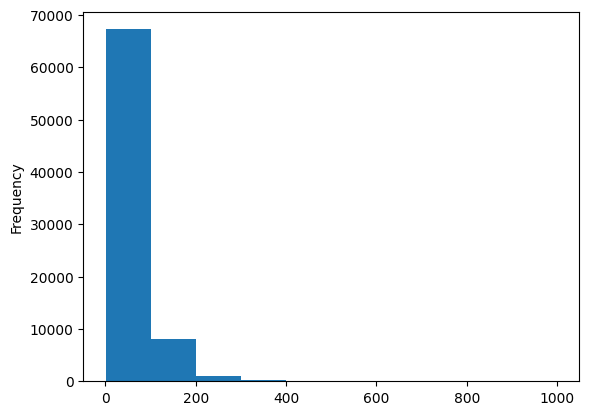

In [44]:
chk_mean_purchase['sale_price'].plot.hist()

In [46]:
print(
    '전체 유저의 평균 지불 금액: 중앙값 {:.2f} | 평균값 {:.2f}'.format(
        np.median(chk_mean_purchase['sale_price'].dropna()), 
        np.mean(chk_mean_purchase['sale_price']))
)

전체 유저의 평균 지불 금액: 중앙값 45.00 | 평균값 59.44


In [47]:
print(
    '1인당 평균 지불 금액: 실험군 ${:.2f} vs 대조군 ${:.2f}'.format(
        np.mean(treatment.groupby('user_id').agg({'sale_price':'mean'})), 
        np.mean(control.groupby('user_id').agg({'sale_price':'mean'})))
)

1인당 평균 지불 금액: 실험군 $60.60 vs 대조군 $59.40


In [48]:
print(
    '제품단가: 중앙값 {:.2f} | 평균값 {:.2f}'.format(
        np.nanmedian(df.groupby('product_name').agg({'sale_price':'mean'})), 
        np.mean(df.groupby('product_name').agg({'sale_price':'mean'})))
)

제품단가: 중앙값 39.99 | 평균값 59.46


In [49]:
test_mean_price = treatment.groupby('user_id').agg({'sale_price':'mean'})
ctrl_mean_price = control.groupby('user_id').agg({'sale_price':'mean'})

In [50]:
# 등분산 검정: pvalue가 0.05보다 크므로 두 표본의 분산이 같다
stats.levene(test_mean_price.dropna(), ctrl_mean_price.dropna())

LeveneResult(statistic=array([0.06476696]), pvalue=array([0.79911498]))

In [ ]:
mean_purchase_treatment = treatment.groupby('user_id')['sale_price'].mean()
mean_purchase_control = control.groupby('user_id')['sale_price'].mean()

In [55]:
var_test = np.var(mean_purchase_treatment)
var_ctrl = np.var(mean_purchase_control)

print('지불 금액의 분산: 실험군 ${:.2f} vs 대조군 ${:.2f}'.format(var_test, var_ctrl))

if (var_test > var_ctrl * 2) or (var_ctrl > var_test * 2):
    print('분산이 2배 이상 차이나므로, Welch\'s t-test')
    equal_var=False
else:
    print('분산이 같으므로, Student\'s t-test')
    equal_var=True

지불 금액의 분산: 실험군 $2861.67 vs 대조군 $3084.45
분산이 같으므로, Student's t-test


In [56]:
t_stat, p_val = stats.ttest_ind(mean_purchase_treatment.dropna(), mean_purchase_control.dropna(),
                                equal_var=equal_var)

print('t-statistic:', t_stat, '   p-value:', p_val)

if p_val < 0.05:
    print('두 그룹이 차이가 있다.')
else:
    print('두 그룹이 차이가 없다.')

t-statistic: 0.9777010494620041    p-value: 0.32822527756898123
두 그룹이 차이가 없다.


### 특정 product 구매
- 2024년 1월 11일부터 판매량이 많은 제품 top 5
- 이 제품을 구매한 유저 수 vs 구매 안한 유저 수

In [256]:
product_top5 = df[df.order_created_at >= '2024-01-11'].product_name.value_counts()[:5].index

In [257]:
print('[Chi-square Analysis Result Report]\n------------------------------------')
for i,product in enumerate(product_top5, start=1):

    test = treatment[treatment.product_name==product].user_id.nunique()
    ctrl = control[control.product_name==product].user_id.nunique()

    ## Part1. Chi-square Test Report
    purchase_product = [test, ctrl] # A와 B의 특정 product를 구매한 유저 수
    unpurchase_product = [treatment.user_id.nunique() - test, 
                control.user_id.nunique() - ctrl]  # A와 B의 특정 product를 구매하지 않은 유저 수
    
    ## Part2. Contingency Table & Chi-squaure Model
    ## 기초 테이블 형성
    cont_table = pd.DataFrame([purchase_product, unpurchase_product], columns=['treatment', 'control'], index=[f'purchase_{product}', f'unpurchase_{product}'])

    ## Part3. 카이제곱 독립성 검정 모델 선언
    chi2, p_val, _, _ = stats.chi2_contingency([purchase_product, unpurchase_product])

    ## 기대값 표 형성
    ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = [f'purchase_{product}', f'unpurchase_{product}'])

    print(
      'Product {}: {}'.format(i, product)
    , 'Chi-square: {}'.format(round(chi2, 2))
    , 'P-value: {}'.format(round(p_val, 2))
    , '--------------------------'
    , 'Expected Values'
    , ex
    , '--------------------------'
    , 'Observed Values'
    , cont_table
    ,  '=========================='
    , sep = '\n'
    )

[Chi-square Analysis Result Report]
------------------------------------
Product 1: Boconi Collins Calf Billfold
Chi-square: 10.92
P-value: 0.0
--------------------------
Expected Values
                                           treatment       control
purchase_Boconi Collins Calf Billfold    1555.094478  54096.905522
unpurchase_Boconi Collins Calf Billfold   504.905522  17564.094478
--------------------------
Observed Values
                                         treatment  control
purchase_Boconi Collins Calf Billfold            2        4
unpurchase_Boconi Collins Calf Billfold       2106    73496
Product 2: 2 PC. Ladies Lace Babydoll Set - One Size - Black/Pink
Chi-square: 52.62
P-value: 0.0
--------------------------
Expected Values
                                                      treatment       control
purchase_2 PC. Ladies Lace Babydoll Set - One S...  1555.094478  54096.905522
unpurchase_2 PC. Ladies Lace Babydoll Set - One...   504.905522  17564.094478
---------------

P-value가 0.0로 0.05보다 작다 -> 두 그룹의 차이가 있다 => 신규 유저가 해당 카테고리를 더 샀다

In [258]:
# 해당 제품들의 첫 입고 시기
for i, product in enumerate(product_top5, start=1):
    print('{}. {:<70}: {}'.format(
        i,
        product,
        df[df.product_name==product].inventory_created_at.min()
    ))

1. Boconi Collins Calf Billfold                                          : 2019-12-11 00:00:00
2. 2 PC. Ladies Lace Babydoll Set - One Size - Black/Pink                : 2019-04-11 00:00:00
3. Port Authority K321 Interlock Knit Mock Turtleneck                    : 2020-01-30 00:00:00
4. Burnside Men's Bedrock Plaid Woven Short                              : 2019-08-25 00:00:00
5. Volcom Men's Nova Modern Straight Leg Fit                             : 2020-01-27 00:00:00


=> 입고 시기는 과거였어도, 결국 해당 제품을 구매한 유저가 4명 ~ 8명인데 두 그룹이 다르다고 할 수 있을까....?ㅜㅜ

In [259]:
category_top5 = df[df.order_created_at >= '2024-01-11'].category.value_counts()[:5].index
print('[Chi-square Analysis Result Report]\n------------------------------------')
for i, category in enumerate(category_top5, start=1):

    test = treatment[treatment.category==category].user_id.nunique()
    ctrl = control[control.category==category].user_id.nunique()

    ## Part1. Chi-square Test Report
    purchase_category = [test, ctrl] # A와 B의 특정 product를 구매한 유저 수
    unpurchase_category = [treatment.user_id.nunique() - test, 
                control.user_id.nunique() - ctrl]  # A와 B의 특정 product를 구매하지 않은 유저 수
    
    ## Part2. Contingency Table & Chi-squaure Model
    ## 기초 테이블 형성
    cont_table = pd.DataFrame([purchase_category, unpurchase_category], columns=['treatment', 'control'], index=[f'purchase_{category}', f'unpurchase_{category}'])

    ## Part3. 카이제곱 독립성 검정 모델 선언
    chi2, p_val, _, _ = stats.chi2_contingency([purchase_category, unpurchase_category])

    ## 기대값 표 형성
    ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = [f'purchase_{category}', f'unpurchase_{category}'])

    print(
      'Product {}: {}'.format(i, category)
    , 'Chi-square: {}'.format(round(chi2, 2))
    , 'P-value: {}'.format(round(p_val, 2))
    , '--------------------------'
    , 'Expected Values'
    , ex
    , '--------------------------'
    , 'Observed Values'
    , cont_table
    ,  '=========================='
    , sep = '\n'
    )

[Chi-square Analysis Result Report]
------------------------------------
Product 1: Intimates
Chi-square: 1.5
P-value: 0.22
--------------------------
Expected Values
                        treatment       control
purchase_Intimates    1555.094478  54096.905522
unpurchase_Intimates   504.905522  17564.094478
--------------------------
Observed Values
                      treatment  control
purchase_Intimates          175     5558
unpurchase_Intimates       1933    67942
Product 2: Fashion Hoodies & Sweatshirts
Chi-square: 2.54
P-value: 0.11
--------------------------
Expected Values
                                            treatment       control
purchase_Fashion Hoodies & Sweatshirts    1555.094478  54096.905522
unpurchase_Fashion Hoodies & Sweatshirts   504.905522  17564.094478
--------------------------
Observed Values
                                          treatment  control
purchase_Fashion Hoodies & Sweatshirts          165     5078
unpurchase_Fashion Hoodies & Sweatshirt